In [1]:
import sys,os
from os.path import join
sys.path.append('/home/monte.flora/python_packages/scikit-explain/')
#sys.path.append('/Users/monte.flora/ml_workflow/')
sys.path.append('/work/mflora/ROAD_SURFACE')
sys.path.append('/Users/monte.flora/Desktop/road_surface/')

from skexplain import ExplainToolkit
from skexplain.common.importance_utils import (to_skexplain_importance, 
                                find_correlated_pairs_among_top_features, 
                                method_average_ranking,)
from skexplain.common.utils import compute_bootstrap_indices


from skexplain.plot.base_plotting import PlotStructure
from matplotlib.lines import Line2D
from glob import glob
import pickle 
from joblib import load 

sys.path.insert(0,'/home/monte.flora/python_packages/compare-explain-methods/src/io')
from display_names import to_readable_names, to_color 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from probsr_config import FIGURE_MAPPINGS

from sklearn.preprocessing import StandardScaler
import xarray as xr

In [2]:
def method_average_ranking(data, features, methods, estimator_names, n_features=12):
    """
    Compute the median ranking across the results of different ranking methods. 
    Also, include the 25-75th percentile ranking uncertainty.
    
    Parameters
    ------------
        data : list of xarray.Dataset
            The set of predictor ranking results to average over. 
        
        methods : list of string 
            The ranking methods to use from the data (see plot_importance for examples)
            
        estimator_names : string or list of strings
            Name of the estimator(s).
    
    Returns
    --------
        rankings_dict_avg : dict 
            feature : median ranking pairs 
        rankings_sorted : np.array 
            Sorted median rankings (lower values indicates higher rank)
        feature_sorted : np.array 
            The features corresponding the ranks in ``rankings_sorted``
        xerr
    
    """
    rankings_dict = {f : [] for f in features}
    for d, method in zip(data, methods):
        for estimator_name in estimator_names:
            features = d[f'{method}_rankings__{estimator_name}'].values[:n_features]
            rankings = {f:i for i, f in enumerate(features)}
            for f in features:
                try:
                    rankings_dict[f].append(rankings[f])
                except:
                    rankings_dict[f].append(np.nan)
    
    max_len = np.max([len(rankings_dict[k]) for k in rankings_dict.keys()])
    for k in rankings_dict.keys():
        l = rankings_dict[k]
        if len(l) < max_len:
            delta = max_len - len(l)
            rankings_dict[k] = l + [np.nan]*delta
        
    rankings_dict_avg = {f : np.nanpercentile(rankings_dict[f], 50) for f in rankings_dict.keys()}
    
    features = np.array(list(rankings_dict_avg.keys()))
    rankings = np.array([rankings_dict_avg[f] for f in features ])
    idxs = np.argsort(rankings)

    rankings_sorted = rankings[idxs]
    features_ranked = features[idxs]
    
    scores = np.array([rankings_dict[f] for f in features_ranked])

    data={}
    data[f"combined_rankings__{estimator_name}"] = (
                    [f"n_vars_avg"],
                    features_ranked,
                )
    data[f"combined_scores__{estimator_name}"] = (
                    [f"n_vars_avg", "n_bootstrap"],
                    scores,
    )
    data = xr.Dataset(data)
    
    return data

In [3]:
def plot_mean_rankings(ax, result,  display_feature_names=FIGURE_MAPPINGS, title=None, estimator='LogisticRegression'):
    """Plot the average ranking from multiple predictor importance methods"""
    n_features = 12
    feature_sorted = list(result[f'combined_rankings__{estimator}'].values[:n_features])
    rankings = result[f'combined_scores__{estimator}'].values[:n_features]

    print(feature_sorted)
    
    
    median_rankings = np.nanpercentile(rankings, 50, axis=1)
    xerr = np.abs( np.nanpercentile(rankings, 50, axis=1) - np.nanpercentile(rankings, [25, 75], axis=1))
    
    y = np.arange(0,len(rankings))
    ax.errorbar(median_rankings,y, xerr=xerr, 

             ecolor='gray', elinewidth=1., lw=2.0, 
             capsize=2.5,
            )
    
    display_names = [display_feature_names.get(f,f) for f in feature_sorted]
    ax.set_yticks(y,)
    ax.set_yticklabels(display_names, fontsize=10)
    plt.gca().invert_yaxis()
    ax.grid(alpha=0.8, ls='--')
    ax.set_xlim([0,n_features])
    ax.set_ylim([n_features,-0.5])

In [4]:
BASE_PATH = '/work/mflora/explainability_work/'
DATA_BASE_PATH = os.path.join(BASE_PATH, 'datasets')
MODEL_BASE_PATH = os.path.join(BASE_PATH, 'models')
RESULTS_PATH = os.path.join(BASE_PATH, 'results')
other_base_path = '/work/mflora/explainability_work/results'

In [5]:
base_plt = PlotStructure(BASE_FONT_SIZE = 16)

def _plot(time, target):

    opts = ['', 'L1_based_feature_selection_with_manual']
    
    df = pd.read_pickle(join(DATA_BASE_PATH, f'{time}_training_matched_to_{target}_0km_dataset'))
    all_features = df.columns
    display_feature_names = {f : to_readable_names(f) for f in all_features}
    feature_colors = {f : to_color(f) for f in all_features}

    titles = ['Original Feature Set', 'Reduced Feature Set']
    base_plt = PlotStructure()
    
    datasets=[]
    method_set = []
    explainers = [] 
    colinear_predictors = []
    results = []
    feature_set = []
    
    for opt in opts:
        model_name = join(MODEL_BASE_PATH, f'LogisticRegression_first_hour_{target}_under_standard_{opt}.pkl')
        data = load(model_name)
        model = data['model']
        X = df[data['features']].astype(float)
        
        if opt == '':
            full_X = X.copy() 
        
        features = data['features']
        
        feature_set.append(features)
        
        explainer = ExplainToolkit(X=X)
        pimp_backward_fname = join(DATA_BASE_PATH, f'permutation_importance_{target}_first_hour_training_norm_aupdc{opt}backward.nc')
        pimp_forward_fname = join(DATA_BASE_PATH, f'permutation_importance_{target}_first_hour_training_norm_aupdc{opt}forward.nc')
        ale_var_fname = join(DATA_BASE_PATH, f'ale_var_results_all_models_{target}_{time}{opt}.nc')
        shap_fname = join(DATA_BASE_PATH, f'shap_values_LogisticRegression_{target}_{time}{opt}.pkl')

        ale_var = explainer.load(ale_var_fname)
        pimp_backward = explainer.load(pimp_backward_fname)
        pimp_forward = explainer.load(pimp_forward_fname)
    
        with open(shap_fname, 'rb') as pkl_file:
            data = pickle.load(pkl_file)

        X = data['X']
        shap_vals = data['shap_values']
        shap_rank = to_skexplain_importance(shap_vals, 
                                      estimator_name='LogisticRegression', 
                                      feature_names=X.columns, 
                                      method ='shap_sum', )

        coefs = model.base_estimator.named_steps['model'].coef_[0]
        coef_rank = to_skexplain_importance(coefs,
                                       estimator_name='LogisticRegression', 
                                       feature_names=X.columns, 
                                        method = 'coefs')
    
        opt_ = 'original' if opt == '' else 'reduced'
        with open(join(DATA_BASE_PATH, f'sage_results_{opt_}_{target}.nc'), 'rb') as f:
            sage_results = pickle.load(f)
        
        sage_rank = to_skexplain_importance(sage_results,
                                       estimator_name='LogisticRegression', 
                                      feature_names=X.columns, 
                                       method = 'sage')
        # lime 

        lime_fname = join(other_base_path,f'lime_rank_{target}_{opt_}.nc')
        lime_rank = explainer.load(lime_fname)

        # Turn the permutation importances into proper importance scores. 
        # Backward multipass and forward singlepass: 1 + (permute score - original score)
        #original_score = pimp_backward['original_score__LogisticRegression'].values
        #scores = 1.0 + (pimp_backward['multipass_scores__LogisticRegression'].values - original_score)
        #pimp_backward['multipass_scores__LogisticRegression'] = (['n_vars_multipass', 'n_permute'], scores)
    
        
        # Forward singlepass : permute score - worst score (since I'm using NAUPDC I can assume zero, so just 
        # the permuted score. )
        #original_score = pimp_forward['original_score__LogisticRegression'].values
        #scores = 1.0 + (pimp_forward['singlepass_scores__LogisticRegression'].values - original_score)
        #pimp_forward['singlepass_scores__LogisticRegression'] = (['n_vars_singlepass', 'n_permute'], scores)
  
        # Backward singlepass and forward multipass: original_score - permuted score
        original_score = pimp_backward['original_score__LogisticRegression'].values
        scores = original_score - pimp_backward['singlepass_scores__LogisticRegression'].values
        pimp_backward['singlepass_scores__LogisticRegression'] = (['n_vars_singlepass', 'n_permute'], scores)
    
        original_score = pimp_forward['original_score__LogisticRegression'].values
        scores = original_score - pimp_forward['multipass_scores__LogisticRegression'].values
        pimp_forward['multipass_scores__LogisticRegression'] = (['n_vars_multipass', 'n_permute'], scores)
        
        _data = [pimp_backward, 
            pimp_backward,
            pimp_forward, 
            pimp_forward,
            ale_var,  
            shap_rank, 
            coef_rank, 
            sage_rank,
            lime_rank, 
            ]
    
        methods = ['multipass', 'singlepass', 'multipass', 'singlepass',
                   'ale_variance', 'shap_sum', 'coefs', 'sage', 'lime' ] 
        
        data=[]
        for ds,m in zip(_data, methods):
            imp = ds[f'{m}_scores__LogisticRegression'].values
            imp[imp==0] = 0.000001
            imp_norm = imp/ (np.percentile(imp, 99) - np.percentile(imp, 1))
            ds[f'{m}_scores__LogisticRegression'] = (['n_vars_multipass', 'n_permute'], imp_norm)
            data.append(ds)
            
        xlabels = ['Backward\nMultipass', 'Backward\nSinglepass', 'Forward\nMultipass', 'Forward\nSinglepass',
                   'ALE-based', 'SHAP', 'Coefs.', ] 
        
        datasets.append(data)
        method_set.append(methods)
        explainers.append(explainer)

        num_vars_to_plot = 12
        result = method_average_ranking(data, features, 
                                        methods, 
                                        estimator_names=['LogisticRegression'], 
                                       n_features=20)
        
        #vif = pd.read_pickle(f'../datasets/vif_{time}_{target}{opt}.pkl')
        #rankings = result[f'combined_rankings__LogisticRegression'].values[:num_vars_to_plot]
        #vif_subset = vif.loc[rankings]['VIF']
        #colinear_predictors.append(np.round(vif_subset,2)>=3.0)
        
        results.append(result)
    
    explainer = ExplainToolkit(X=full_X)
    '''
    panels = [('combined', 'LogisticRegression'), ('combined', 'LogisticRegression') ]
    f, axes = explainer.plot_importance(data=results, 
                          panels = panels, 
                          display_feature_names=display_feature_names,
                         feature_colors = feature_colors,
                         plot_correlated_features=True,
                         rho_threshold=0.7,
                         colinear_predictors=colinear_predictors,
                         xticks = np.arange(0,num_vars_to_plot+2,2),
                         num_vars_to_plot=num_vars_to_plot,
                         )
    for ax, title in zip(axes, titles):
        ax.set_title(title)
    '''
    
    return datasets, method_set, explainers, display_feature_names, feature_colors, xlabels, results

# TORNADO

In [6]:
(datasets, method_set, explainers, display_feature_names, feature_colors, 
 xlabels, torn_results)= _plot(time='first_hour', target='tornado')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
All-NaN slice encountered


In [7]:
%%script false --no-raise-error
f, axes = base_plt.create_subplots(n_panels=2, n_columns=2, figsize=(8,5), dpi=300, 
                                      wspace=0.6, hspace=1.5)

for result, label, ax in zip(torn_results, ['Original Feature Set', 'Reduced Feature Set'], axes.flat):
    plot_mean_rankings(ax, result,   
                       display_feature_names=display_feature_names, 
                       title='Tornado')
    ax.set_title(label, fontsize=12)

major_ax = base_plt.set_major_axis_labels(f, xlabel='Median Rankings', 
                              )
major_ax.grid(False)
base_plt.add_alphabet_label(n_panels=2, axes=axes, pos=(0.925, 0.95), fontsize=16)
major_ax.set_title('Tornado', color = 'xkcd:medium blue', fontsize=16)

# SEVERE HAIL

In [8]:
(datasets, method_set, explainers, display_feature_names, feature_colors, 
 xlabels, hail_results) = _plot(time='first_hour', target='severe_hail')

All-NaN slice encountered
All-NaN slice encountered


In [9]:
%%script false --no-raise-error
for data, methods, explainer in zip(datasets, method_set, explainers):
    panels = [(m, 'LogisticRegression') for m in ['singlepass']]
    explainer.plot_importance(data=[data[0]], 
                         panels = panels, 
                         display_feature_names=display_feature_names,
                         feature_colors = feature_colors,
                         plot_correlated_features=True,
                         rho_threshold=0.5,
                         xlabels=['Single-Pass', 'SHAP'],
                         ) 

# SEVERE WIND

In [10]:
(datasets, method_set, explainers, display_feature_names, feature_colors, 
 xlabels, wind_results) = _plot(time='first_hour', target='severe_wind')

All-NaN slice encountered


In [11]:
%%script false --no-raise-error
f, axes = base_plt.create_subplots(n_panels=2, n_columns=2, figsize=(8,5), dpi=300, 
                                      wspace=0.6, hspace=1.5)

for result, label, ax in zip(wind_results, ['Original Feature Set', 'Reduced Feature Set'], axes.flat):
    plot_mean_rankings(ax, result,   
                       display_feature_names=display_feature_names, 
                       title='Severe Wind')
    ax.set_title(label, fontsize=12)

major_ax = base_plt.set_major_axis_labels(f, xlabel='Median Rankings', 
                              )
major_ax.grid(False)
base_plt.add_alphabet_label(n_panels=2, axes=axes, pos=(0.925, 0.95), fontsize=16)
major_ax.set_title('Severe Wind', color = 'xkcd:medium blue', fontsize=16)

In [13]:
%%script false --no-raise-error
for data, methods, explainer in zip(datasets, method_set, explainers):
    panels = [(m, 'LogisticRegression') for m in methods]
    explainer.plot_importance(data=data, 
                         panels = panels, 
                         display_feature_names=display_feature_names,
                         feature_colors = feature_colors,
                         plot_correlated_features=True,
                         rho_threshold=0.5,
                        xlabels=xlabels,
                         ) 

# ROAD SURFACE TEMPS

In [14]:
target = 'Sub-Freezing Road Temperatures'

opts = ['original', 'reduced']
titles = ['Original Feature Set', 'Reduced Feature Set']

road_results=[]
datasets=[]
for opt in opts:
    if opt == 'original':
        model_name = join(MODEL_BASE_PATH, f'JTTI_ProbSR_RandomForest.pkl')
        model = load(model_name)
        gini_values = model.feature_importances_
    else:
        model_name = join(MODEL_BASE_PATH, f'RandomForest_manualfeatures_12.joblib')
        model = load(model_name)['model'] 
        gini_values = model.base_estimator.named_steps['model'].feature_importances_
        
    explainer = ExplainToolkit()
    pimp_backward_fname = join(DATA_BASE_PATH, f'perm_imp_{opt}_backward.nc')
    pimp_forward_fname = join(DATA_BASE_PATH, f'../datasets/perm_imp_{opt}_forward.nc')
    ale_var_fname = join(DATA_BASE_PATH, f'ale_var_rf_{opt}.nc')
    shap_fname = join(DATA_BASE_PATH, f'shap_rf_{opt}.nc')

    ale_var = explainer.load(ale_var_fname)
    pimp_backward = explainer.load(pimp_backward_fname)
    pimp_forward = explainer.load(pimp_forward_fname)

    with open(shap_fname, 'rb') as pkl_file:
        data = pickle.load(pkl_file)

    X = data['X']
    if opt == 'original':
        full_X = X
    
    features = list(X.columns)
    explainer = ExplainToolkit(X=X)
    shap_vals = data['shap_values']
    
    with open(join(DATA_BASE_PATH, f'sage_results_{opt}_road_surface.nc'), 'rb') as f:
        sage_results = pickle.load(f)
        
    sage_rank = to_skexplain_importance(sage_results,
                                       estimator_name='Random Forest', 
                                      feature_names=X.columns, 
                                       method = 'sage')
    
    shap_rank = to_skexplain_importance(shap_vals, 
                                      estimator_name='Random Forest', 
                                      feature_names=X.columns, 
                                    method='shap_sum')

    gini_rank = to_skexplain_importance(gini_values,
                                       estimator_name='Random Forest', 
                                       feature_names=X.columns, 
                                         method = 'gini')
    
    # lime
    lime_fname = join(other_base_path,f'lime_rank_road_surface_{opt}.nc')
    lime_rank = explainer.load(lime_fname)
    
    #ti
    ti_fname = join(other_base_path, f'ti_rank_road_surface_{opt}.nc')
    ti_rank = explainer.load(ti_fname)
    
    
    data = [pimp_backward, 
        pimp_backward,
        pimp_forward, 
        pimp_forward,
        ale_var,  
        shap_rank, 
        gini_rank, 
        lime_rank, 
        ti_rank, 
        ]
    
    methods = ['multipass', 'singlepass', 'multipass', 'singlepass','ale_variance', 'shap_sum', 'gini',
              'lime', 'tree_interpreter'] 

    result = method_average_ranking(data, features, methods, estimator_names=['Random Forest'], n_features=30)
        
    road_results.append(result)
    datasets.append(data)
    
explainer = ExplainToolkit(X=full_X)
'''
panels = [('combined', 'Random Forest'), ('combined', 'Random Forest') ]
f, axes = explainer.plot_importance(data=road_results, 
                          panels = panels, 
                          display_feature_names=FIGURE_MAPPINGS,
                         plot_correlated_features=False,
                         rho_threshold=0.5,
                         )

for ax, title in zip(axes, titles):
    ax.set_title(title)
'''

"\npanels = [('combined', 'Random Forest'), ('combined', 'Random Forest') ]\nf, axes = explainer.plot_importance(data=road_results, \n                          panels = panels, \n                          display_feature_names=FIGURE_MAPPINGS,\n                         plot_correlated_features=False,\n                         rho_threshold=0.5,\n                         )\n\nfor ax, title in zip(axes, titles):\n    ax.set_title(title)\n"

In [15]:
%%script false --no-raise-error
f, axes = base_plt.create_subplots(n_panels=2, n_columns=2, figsize=(8,5), dpi=300, 
                                      wspace=0.6, hspace=1.5)

for result, label, ax in zip(results, ['Original Feature Set', 'Reduced Feature Set'], axes.flat):
    plot_mean_rankings(ax, result,   
                       display_feature_names=FIGURE_MAPPINGS, 
                       title='Road Surface', 
                      estimator='Random Forest')
    ax.set_title(label, fontsize=12)

major_ax = base_plt.set_major_axis_labels(f, xlabel='Median Rankings', 
                              )
major_ax.grid(False)
base_plt.add_alphabet_label(n_panels=2, axes=axes, pos=(0.925, 0.95), fontsize=16)
major_ax.set_title('Road Surface', color = 'xkcd:medium blue', fontsize=16)

In [16]:
%%script false --no-raise-error
for data in datasets:
    panels = [(m, 'Random Forest') for m in methods]
    explainer.plot_importance(data=data, 
                         panels = panels, 
                         display_feature_names=FIGURE_MAPPINGS,
                         plot_correlated_features=True,
                         rho_threshold=0.5,
                        xlabels=xlabels,
                              figsize=(8,6)
                         ) 

In [19]:
_datasets = [torn_results, wind_results, hail_results,  road_results]
names = ['tornado', 'wind', 'hail', 'road']

vals = []
for name, results in zip(names, _datasets):
    for i, mode in enumerate(['Original', 'Reduced']): 
        print(mode, name)
        val, val_std = average_norm_rank_var(get_data(results[i]), use_top=True)
        vals.append(val)

Original tornado
Reduced tornado
Original wind
Reduced wind
Original hail
Reduced hail
Original road
Reduced road


the `interpolation=` argument to nanpercentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
the `interpolation=` argument to nanpercentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
the `interpolation=` argument to nanpercentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


['wz_0to2_time_max_ens_mean_of_90th', 'divergence_10m_time_min_ens_mean_spatial_mean', 'minor_axis_length', 'ws_80_time_max_ens_mean_spatial_mean', 'hailcast_time_max_ens_mean_of_90th', 'major_axis_length', 'uh_0to2_time_max_ens_std_spatial_mean', 'v_10_ens_mean_spatial_mean', 'divergence_10m_time_min_ens_mean_of_10th', 'shear_v_0to6_ens_mean_spatial_mean', 'uh_2to5_time_max_ens_mean_spatial_mean', 'w_up_time_max_ens_mean_of_90th']
['wz_0to2_time_max_ens_mean_of_90th', 'uh_2to5_time_max_ens_mean_of_90th', 'comp_dz_time_max_ens_mean_of_90th', 'hailcast_time_max_ens_mean_of_90th', 'shear_v_0to1_ens_mean_spatial_mean', 'major_axis_length', 'cape_ml_ens_mean_spatial_mean', 'geopotential_height_500mb_ens_mean_spatial_mean', 'minor_axis_length', 'shear_v_0to6_ens_mean_spatial_mean', 'cin_ml_ens_std_spatial_mean', 'Initialization Time']
['ws_80_time_max_ens_mean_of_90th', 'comp_dz_time_max_ens_mean_of_90th', 'wz_0to2_time_max_ens_mean_of_90th', 'lcl_ml_ens_mean_spatial_mean', 'divergence_10m_

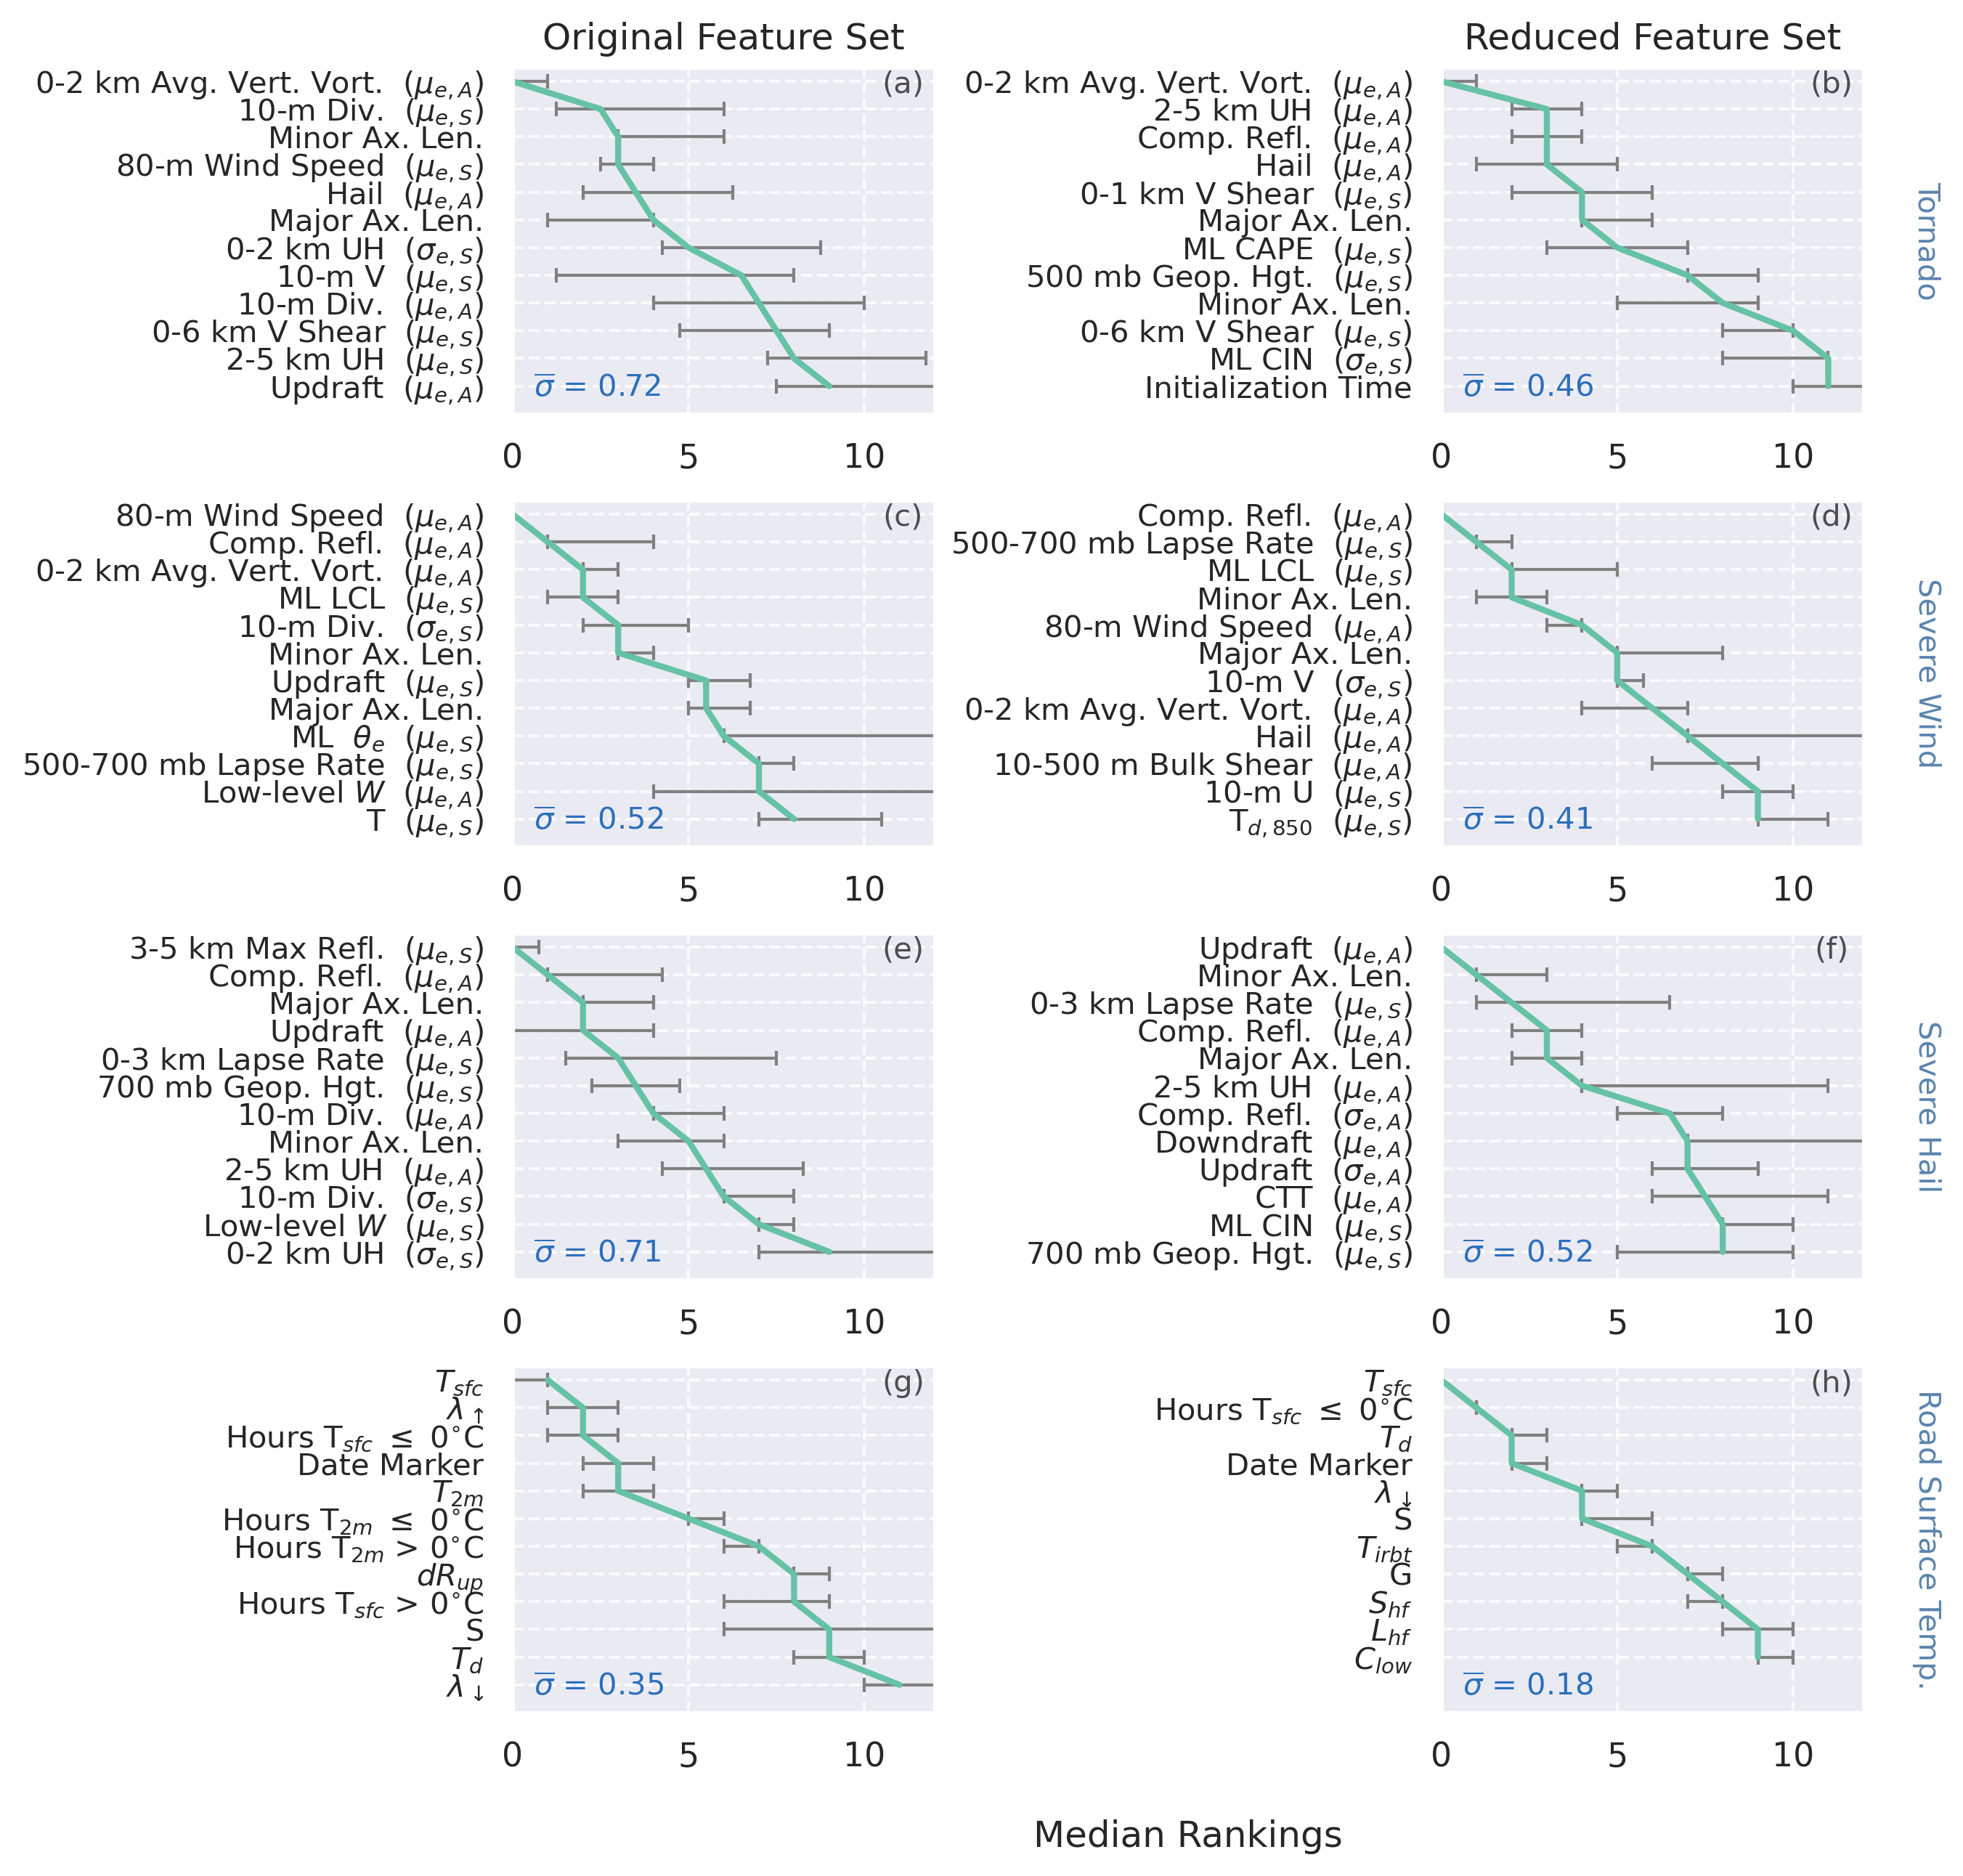

In [20]:
base_plt = PlotStructure(BASE_FONT_SIZE = 12)

import seaborn as sns
sns.set_theme(palette=sns.color_palette("Set2"))

f, axes = base_plt.create_subplots(n_panels=8, n_columns=2, figsize=(8,10), dpi=300, 
                                      wspace=1.2, hspace=0.25)


labels = ['Original Feature Set', 'Reduced Feature Set']

for i, ax in enumerate(axes.flat):
    if i in [0,1]:
        plot_mean_rankings(ax, torn_results[i],   
                       display_feature_names=display_feature_names, 
                       title='Tornado')
        ax.set_title(labels[i], fontsize=12)
        
    elif i in [2,3]:
        plot_mean_rankings(ax, wind_results[i-2],   
                       display_feature_names=display_feature_names, 
                       title='Tornado')

    elif i in [4,5]:
        plot_mean_rankings(ax, hail_results[i-4],   
                       display_feature_names=display_feature_names, 
                       title='Tornado')
    else:
        plot_mean_rankings(ax, road_results[i-6],   
                       display_feature_names=FIGURE_MAPPINGS, 
                       title='Road Surface', 
                       estimator='Random Forest')

    txt = fr'$\overline{{\sigma}}$ = {vals[i]:.02f}'
    ax.annotate(txt, (0.05, 0.05), xycoords='axes fraction', fontsize=10, color = 'xkcd:medium blue')

    #if i in [0,2,4,6]:
    #    ax.set_xlim([0,15])

major_ax = base_plt.set_major_axis_labels(f, xlabel='Median Rankings', 
                              )
major_ax.grid(False)
base_plt.add_alphabet_label(n_panels=8, axes=axes, pos=(0.925, 0.95), fontsize=16)
labels = ['Tornado', 'Severe Wind', 'Severe Hail', 'Road Surface Temp.']
base_plt.set_row_labels(labels, 
                        axes, 
                        pos=-1, 
                        pad=1.15, 
                        rotation=270,
                       )

## Compute the average normalized feature ranking variance 

In [18]:
def get_features(results):
    try:
        return results['combined_rankings__LogisticRegression'].values
    except:
        return results['combined_rankings__Random Forest'].values
    
def get_data(results):
    try:
        return results['combined_scores__LogisticRegression'].values 
    except:
        return results['combined_scores__Random Forest'].values 
    
def get_indices(original_features, reduced_features):
    return [i for i, f in enumerate(original_features) if f in reduced_features]

def average_norm_rank_var(data, use_top=False):
    """
    Computes the average normalized feature ranking variance. 
    
    ___     1      IQR(R_i)
    σ(R) = --- E ( -------- )
            N       Med(R_i)
            
    Parameters
    ---------------
    data, array-like of shape (n_features, n_methods)        
    """
    if use_top:
        data = data[:15]
        
    iqr = np.nanpercentile(data, 75, axis=1, 
                           interpolation='nearest') - np.nanpercentile(data, 25, axis=1, interpolation='nearest')
    med = np.nanpercentile(data, 50, axis=1, interpolation='nearest')+1
    
    val = iqr/med 
    
    return np.nanmean(val), np.nanstd(val, ddof=1)

In [ ]:
_datasets = [torn_results, wind_results, hail_results,  road_results]
names = ['tornado', 'wind', 'hail', 'road']

vals = []
for name, results in zip(names, _datasets):
    for i, mode in enumerate(['Original', 'Reduced']): 
        print(mode, name)
        val, val_std = average_norm_rank_var(get_data(results[i]), use_top=True)
        vals.append(val)

In [24]:
datasets = [wind_results, hail_results, torn_results, road_results]
names = ['Severe Wind', 'Severe Hail', 'Tornado', 'Road Surface']

### Comparing the ranking uncertainty between the top 15 features per dataset

In [25]:
print('Average Normalized Feature Ranking Variance (top 15 features)')
print('='*50)
for name, results in zip(names, datasets):
    print(name)
    for i, mode in enumerate(['Original', 'Reduced']):
        val, val_std = average_norm_rank_var(get_data(results[i]), use_top=True)
        print(f'{mode} Dataset: {val:.03f} +/- {val_std:.05f}')

    print('='*50)

Average Normalized Feature Ranking Variance (top 15 features)
Severe Wind
Original Dataset: 0.520 +/- 0.45830
Reduced Dataset: 0.408 +/- 0.35802
Severe Hail
Original Dataset: 0.707 +/- 0.62333
Reduced Dataset: 0.518 +/- 0.48156
Tornado
Original Dataset: 0.724 +/- 0.48316
Reduced Dataset: 0.462 +/- 0.30429
Road Surface
Original Dataset: 0.349 +/- 0.20213
Reduced Dataset: 0.177 +/- 0.13284


the `interpolation=` argument to nanpercentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
the `interpolation=` argument to nanpercentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
the `interpolation=` argument to nanpercentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


### Comparing the ranking uncertainty between the same set of features depending on the hazard.

In [26]:
print('Average Normalized Feature Ranking Variance (Same Features Per Dataset)')
print('='*50)

for name, results in zip(names, datasets):
    print(name)
    original_features = get_features(results[0])
    reduced_features = get_features(results[1])
    inds = get_indices(original_features, reduced_features)
    
    for i, mode in enumerate(['Original', 'Reduced']):
        if mode == 'Original':
            data = get_data(results[i])[inds, :]
        else:
            data = get_data(results[i])
        
        val, val_std = average_norm_rank_var(data, use_top=True)
        print(f'{mode} Dataset: {val:.03f} +/- {val_std:.05f}')

    print('='*50)

Average Normalized Feature Ranking Variance (Same Features Per Dataset)
Severe Wind
Original Dataset: 0.366 +/- 0.44402
Reduced Dataset: 0.408 +/- 0.35802
Severe Hail
Original Dataset: 0.636 +/- 0.67560
Reduced Dataset: 0.518 +/- 0.48156
Tornado
Original Dataset: 0.409 +/- 0.30386
Reduced Dataset: 0.462 +/- 0.30429
Road Surface
Original Dataset: 0.317 +/- 0.21691
Reduced Dataset: 0.177 +/- 0.13284


the `interpolation=` argument to nanpercentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
the `interpolation=` argument to nanpercentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
the `interpolation=` argument to nanpercentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


In [27]:
import itertools 

data_order = np.array(['backward_multipass', 'backward_singlepass', 'forward_multipass', 'forward_singlepass',
                   'ale_variance', 'shap_sum', 'coefs', ])
top_inds = [1,5,6]

print('Average Normalized Feature Ranking Variance (Top 15 Features)')
print(f'***Treating {data_order[top_inds]} as the top methods***')
print('='*75)

dots_same = {'Original' : [], 
        'Reduced' : []}

for name, results in zip(names, datasets):
     for i, mode in enumerate(['Original', 'Reduced']):
        data = get_data(results[i])
    
        val, val_std = average_norm_rank_var(data, use_top=True)
        top_val, top_val_std = average_norm_rank_var(data[:, top_inds], use_top=True)
        arr = [average_norm_rank_var(data[:, list(inds)], use_top=True)[0] 
             for inds in itertools.combinations(range(data.shape[1]-1), r=3) if inds != tuple(top_inds)]
        
        rand_val, rand_std = np.nanmean(arr), np.nanstd(arr, ddof=1)

        title = f'{mode} {name}'
        
        print('\n', title)
        print('*'*(len(title)+3))
        print(f'All Methods                : {val:.03f} +/- {val_std:.05f}')
        print(f'Top 3 Methods              : {top_val:.03f} +/- {top_val_std:.05f}')
        print(f'Avg. from 3 Random Methods : {rand_val:.03f} +/- {rand_std:.05f}')
        print(f'Ratio b/t Top and Random   : {top_val/rand_val:.03f}')
    
        dots_same[mode].append(top_val/rand_val)
    
     print('='*50)

Average Normalized Feature Ranking Variance (Top 15 Features)
***Treating ['backward_singlepass' 'shap_sum' 'coefs'] as the top methods***

 Original Severe Wind
***********************
All Methods                : 0.520 +/- 0.45830
Top 3 Methods              : 0.311 +/- 0.45450
Avg. from 3 Random Methods : 0.915 +/- 0.40775
Ratio b/t Top and Random   : 0.340


the `interpolation=` argument to nanpercentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
the `interpolation=` argument to nanpercentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
the `interpolation=` argument to nanpercentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
All-NaN slice encountered



 Reduced Severe Wind
**********************
All Methods                : 0.408 +/- 0.35802
Top 3 Methods              : 0.529 +/- 0.58492
Avg. from 3 Random Methods : 0.552 +/- 0.18507
Ratio b/t Top and Random   : 0.958

 Original Severe Hail
***********************
All Methods                : 0.707 +/- 0.62333
Top 3 Methods              : 0.287 +/- 0.36925
Avg. from 3 Random Methods : 1.242 +/- 0.53789
Ratio b/t Top and Random   : 0.231

 Reduced Severe Hail
**********************
All Methods                : 0.518 +/- 0.48156
Top 3 Methods              : 0.519 +/- 0.51232
Avg. from 3 Random Methods : 0.733 +/- 0.22610
Ratio b/t Top and Random   : 0.708

 Original Tornado
*******************
All Methods                : 0.724 +/- 0.48316
Top 3 Methods              : 1.463 +/- 2.26408
Avg. from 3 Random Methods : 1.135 +/- 0.42756
Ratio b/t Top and Random   : 1.290

 Reduced Tornado
******************
All Methods                : 0.462 +/- 0.30429
Top 3 Methods              : 0.498 +

In [28]:
data_order = np.array(['backward_multipass', 'backward_singlepass', 'forward_multipass', 'forward_singlepass',
                   'ale_variance', 'shap_sum', 'coefs', ])

top_inds = [1,5,6]

top_inds = {'Original': {'Severe Wind' : ['forward_multipass', 'ale_variance', 'shap_sum' ],
                         'Severe Hail' : ['coefs', 'shap_sum', 'backward_singlepass'],
                         'Tornado' : ['coefs', 'shap_sum', 'backward_singlepass'  ],
                         'Road Surface' : ['shap_sum', 'backward_singlepass', 'ale_variance', ],
                        
                        },
            'Reduced': {'Severe Wind' : ['coefs', 'forward_multipass', 'backward_singlepass'],
                         'Severe Hail' : ['backward_singlepass', 'forward_multipass', 'shap_sum'  ],
                         'Tornado' : ['coefs', 'shap_sum', 'backward_singlepass' ],
                         'Road Surface' : [ 'shap_sum', 'backward_singlepass', 'ale_variance',],
                        
                        },
           }


print('Average Normalized Feature Ranking Variance (Top 15 Features)')
print(f'***Using a dataset-dependent top 3 methods***')
print('='*75)

dots_different = {'Original' : [], 
        'Reduced' : []}

for name, results in zip(names, datasets):
     for i, mode in enumerate(['Original', 'Reduced']):
        data = get_data(results[i])
        
        _inds = top_inds[mode][name]
        _inds = [i for i, n in enumerate(data_order) if n in _inds]
        
        val, val_std = average_norm_rank_var(data, use_top=True)
        top_val, top_val_std = average_norm_rank_var(data[:, _inds], use_top=True)
        arr = [average_norm_rank_var(data[:, list(inds)], use_top=True)[0] 
             for inds in itertools.combinations(range(data.shape[1]-1), r=3) if inds != tuple(_inds)]
        
        rand_val, rand_std = np.nanmean(arr), np.nanstd(arr, ddof=1)

        title = f'{mode} {name}'
        
        print('\n', title)
        print('*'*(len(title)+3))
        print(f'All Methods                : {val:.03f} +/- {val_std:.05f}')
        print(f'Top 3 Methods              : {top_val:.03f} +/- {top_val_std:.05f}')
        print(f'Avg. from 3 Random Methods : {rand_val:.03f} +/- {rand_std:.05f}')
        print(f'Ratio b/t Top and Random   : {top_val/rand_val:.03f}')
    
        dots_different[mode].append(top_val/rand_val)
    
     print('='*50)

Average Normalized Feature Ranking Variance (Top 15 Features)
***Using a dataset-dependent top 3 methods***


the `interpolation=` argument to nanpercentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
the `interpolation=` argument to nanpercentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
the `interpolation=` argument to nanpercentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



 Original Severe Wind
***********************
All Methods                : 0.520 +/- 0.45830
Top 3 Methods              : 0.802 +/- 0.93392
Avg. from 3 Random Methods : 0.906 +/- 0.41556
Ratio b/t Top and Random   : 0.886

 Reduced Severe Wind
**********************
All Methods                : 0.408 +/- 0.35802
Top 3 Methods              : 0.418 +/- 0.36926
Avg. from 3 Random Methods : 0.554 +/- 0.18418
Ratio b/t Top and Random   : 0.754

 Original Severe Hail
***********************
All Methods                : 0.707 +/- 0.62333
Top 3 Methods              : 0.287 +/- 0.36925
Avg. from 3 Random Methods : 1.242 +/- 0.53789
Ratio b/t Top and Random   : 0.231

 Reduced Severe Hail
**********************
All Methods                : 0.518 +/- 0.48156
Top 3 Methods              : 0.560 +/- 0.57885
Avg. from 3 Random Methods : 0.732 +/- 0.22675
Ratio b/t Top and Random   : 0.765

 Original Tornado
*******************
All Methods                : 0.724 +/- 0.48316
Top 3 Methods             

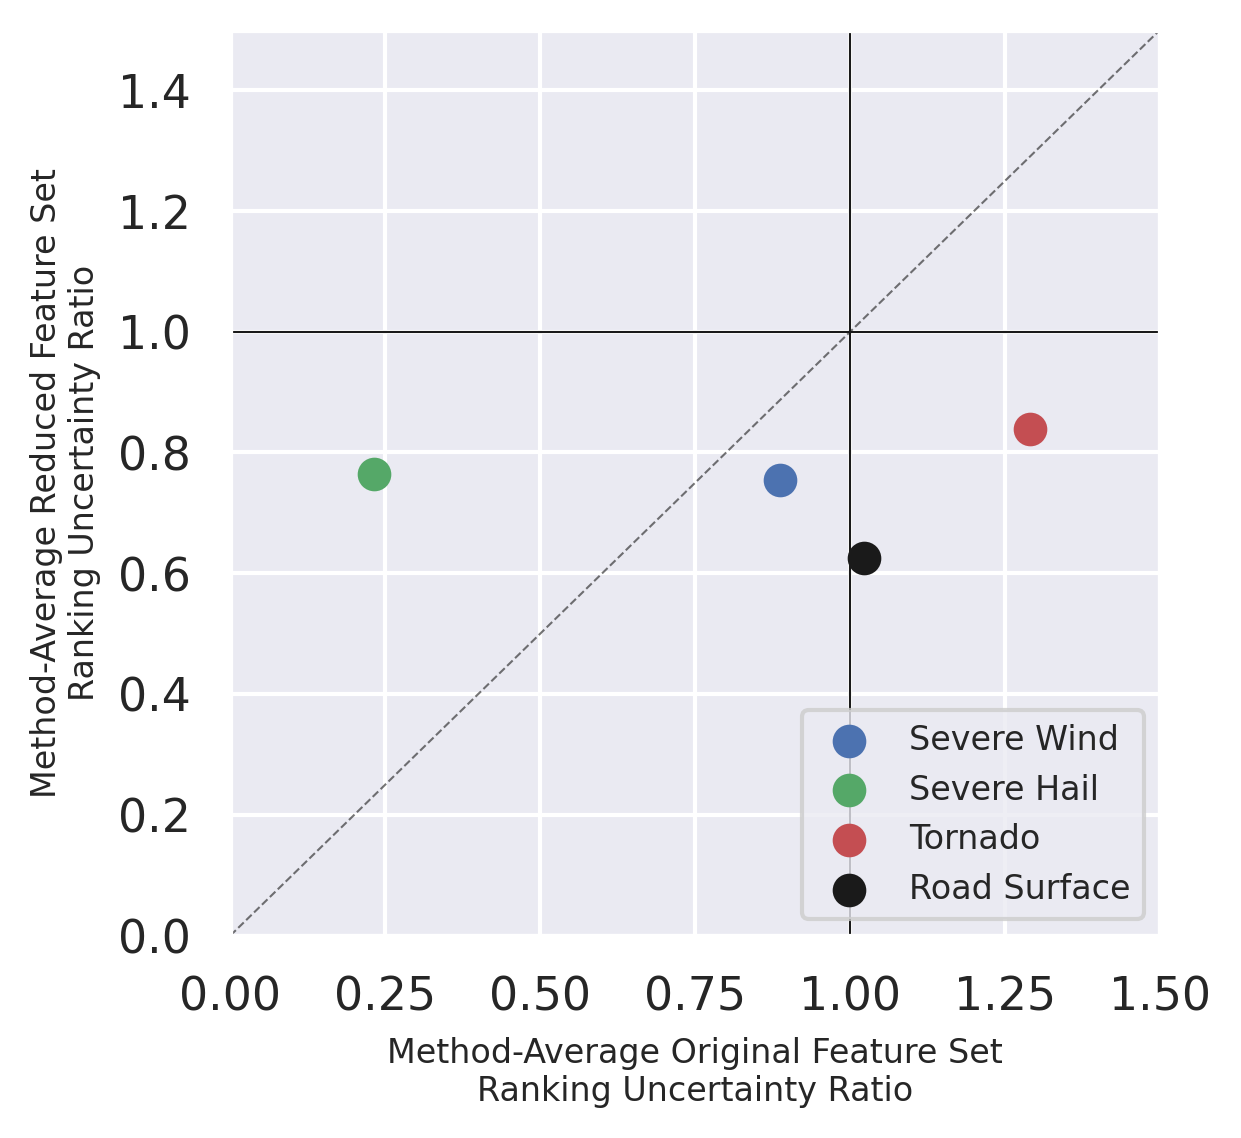

In [30]:
f, ax = plt.subplots(dpi=300, figsize=(4,4), )

names = ['Severe Wind', 'Severe Hail', 'Tornado', 'Road Surface']
colors = ['b', 'g', 'r', 'k']

x = [0, 1, 1]
y = [0, 0, 1]


#ax.fill(x,y, alpha=0.3)

for o,r,c, name in zip(dots_different['Original'], dots_different['Reduced'], colors, names):
    ax.scatter([o], [r], color=c, label=name, s=50)

ax.set_xlim([0, 1.5])
ax.set_ylim([0, 1.5])

ax.set_xlabel('Method-Average Original Feature Set\nRanking Uncertainty Ratio', fontsize=8)
ax.set_ylabel('Method-Average Reduced Feature Set\nRanking Uncertainty Ratio', fontsize=8)

x = np.linspace(0,2, 100)
ax.plot(x,x, ls='dashed', alpha=0.6, color='k', lw='0.5')
ax.axvline(1.0, lw=0.5, color='k')
ax.axhline(1.0, lw=0.5, color='k')
ax.legend(loc = 'lower right', fontsize=8)